In [26]:
from google.colab import drive 
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/HDA*.py
!cat '/content/gdrive/My Drive/Colab Notebooks/HDA/utils_ds.py'
!cat '/content/gdrive/My Drive/Colab Notebooks/HDA/utils.py'
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/HDA')

path = '/content/gdrive/My Drive/Colab Notebooks/HDA'

import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom

import utils_ds
from utils import ModelSaveCallback, create_masked_ds, extract_maskedimage, scaling01, var_of_laplacian, rgb2gray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/HDA*.py': No such file or directory
import numpy as np
import h5py
import tensorflow as tf
import os
import pandas as pd
from PIL import Image


def load_dataset(filename):
    hf = h5py.File(filename, "r")
    dataset_orig = hf["dataset"][:]
    labels_orig = hf["labels"][:]
    classes_orig = hf["classes"][:]
    
    return dataset_orig, labels_orig, classes_orig

def load_dataset_tvt(filename):
    hf = h5py.File(filename, "r")
    train = hf["train"][:]
    labels_train = hf["labels_train"][:]
    valid = hf["valid"][:]
    labels_valid = hf["labels_valid"][:]
    test = hf["test"][:]
    labels_test = hf["labels_test"][:]
    
    return train, labels_train, valid, labels_valid, test, labels_test


def save_ds_h5(filename, dataset, labels, classes):
    hf = h5py.File(filename, 'w')
    hf.cr

In [27]:
filename = 'lsc_TVT_RGB_NOartifacts_resize224.h5'
x_train, y_train, x_valid, y_valid, x_test, y_test = utils_ds.load_dataset_tvt(path+'/datasets/'+filename)
print(path+'/datasets/'+filename)

/content/gdrive/My Drive/Colab Notebooks/HDA/datasets/lsc_TVT_RGB_NOartifacts_resize224.h5


In [ ]:
def data_augmentation(image):
    return [image]
times = 1
name_aug = 'NOaug'

In [28]:
def data_augmentation(image):
    img90 = np.rot90(image)
    img180 = np.rot90(img90)
    img270 = np.rot90(img180)
    imgflip = np.flipud(image)
    imgflip90 = np.rot90(imgflip)
    imgflip180 = np.rot90(imgflip90)
    imgflip270 = np.rot90(imgflip180)
    return np.stack((image, img90, img180, img270, imgflip, imgflip90, imgflip180, imgflip270))
times = 8
name_aug = '8aug'

In [29]:
x_train_aug = np.concatenate((list(map(lambda img: data_augmentation(img),x_train))))
y_train_aug = np.tile(y_train,(times,1)).T.flatten(); 

labels_train = utils_ds.convert_to_one_hot(np.array(y_train_aug), 3).T 
labels_valid = utils_ds.convert_to_one_hot(np.array(y_valid), 3).T
labels_test = utils_ds.convert_to_one_hot(np.array(y_test), 3).T

train_length = y_train_aug.shape[0]
valid_length = y_valid.shape[0]
test_length = y_test.shape[0]

batch_size = 32

img_shape = x_train_aug[0].shape # (224, 224, 3)

train_steps = int(np.ceil(train_length/batch_size))
valid_steps = int(np.ceil(valid_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

In [30]:
tf_train = utils_ds.create_tf_dataset(x_train_aug, labels_train, batch_size, normalize=False, shuffle=True, repeat=False, cache_file=False)
tf_valid = utils_ds.create_tf_dataset(x_valid, labels_valid, batch_size, normalize=False, shuffle=False, repeat=False, cache_file=False)

print(tf.data.experimental.cardinality(tf_train)); print(tf_train)
print(tf.data.experimental.cardinality(tf_valid)); print(tf_valid)

tf.Tensor(56, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
tf.Tensor(3, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>


# Our architecture

<img src="images/proposed_resnet.png" style="width:800px;height:300px;">

<img src="images/blocks.png" style="width:400px;height:350px;">

In [31]:
def ResBlock(x, kernelsize, filters):
    fx = tf.keras.layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = tf.keras.layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

def our_nn(input_shape):

    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.Conv2D(32, (1,1), (1,1), padding = 'same', activation = None)(X_input)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 32)
    X = ResBlock(X, kernelsize=(1, 1), filters = 32)
    X = tf.keras.layers.MaxPooling2D((2,2), strides = (2,2), padding = 'same')(X)

    X = tf.keras.layers.Conv2D(64, (1,1), (1,1), padding = 'same', activation = None)(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 64)
    X = ResBlock(X, kernelsize=(1, 1), filters = 64)
    X = tf.keras.layers.MaxPooling2D((2,2), strides = (2,2), padding = 'same')(X)

    X = tf.keras.layers.Conv2D(128, (1,1), (1,1), padding = 'same', activation = None)(X)
    X = tf.keras.layers.BatchNormalization(axis = -1)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = ResBlock(X, kernelsize=(3, 3), filters = 128)
    X = ResBlock(X, kernelsize=(1, 1), filters = 128)
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    X = tf.keras.layers.Dense(3, activation = 'softmax')(X)
                                    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='our_nn') 

    return model



def fusion_branch(input_shape):
    inputs = keras.Input(shape = input_shape, name='input_fusion_branch')
    x = keras.layers.BatchNormalization()(inputs)
    outputs = keras.layers.Dense(3,activation='softmax')(x)
    model = keras.Model(inputs, outputs, name = 'fusion_branch')
    return model

# Visual attention approach

<img src="images/visual_attention.png" style="width:400px;height:300px;">

# Global branch


In [32]:
my_global_branch = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/HDA/our_models/ourmodel_RGB_NOartifacts_resize224_8aug_our_nn_global_adamax_variable.h5')
my_global_branch.summary()

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 32  128         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 224, 224, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                            

In [ ]:
# my_global_branch = our_nn(img_shape)
# my_global_branch.summary()

In [ ]:
# fixed learning rate
epochs = 25
prova = '_' + my_global_branch.name + '_global'
optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.00001)
optimizer_name = '_adamax_fixed' 
loss = 'categorical_crossentropy'
metrics = ['accuracy']
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+name_aug+prova+optimizer_name+'.h5'
saving = ModelSaveCallback(savename)
my_global_branch.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# variable learning rate
epochs = 25
prova = '_' + my_global_branch.name + '_global'
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=56*40, decay_rate=.0001) # 1e-03 to 1e-7
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
optimizer_name = '_adamax_variable' 
loss = 'categorical_crossentropy'
metrics = ['accuracy']
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+name_aug+prova+optimizer_name+'.h5'
saving = ModelSaveCallback(savename)
my_global_branch.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_curr = my_global_branch.fit(tf_train, epochs=epochs, verbose='auto', validation_data=tf_valid, callbacks=[saving], steps_per_epoch=train_steps, validation_steps=valid_steps)
np.save(savename[:-3]+'_history.npy',history_curr.history)

Epoch 1/25
 6/56 [==>...........................] - ETA: 16s - loss: 1.4389 - accuracy: 0.6042

56/56 [==============================] - 21s 339ms/step - loss: 0.5461 - accuracy: 0.7902 - val_loss: 0.4911 - val_accuracy: 0.8400
Epoch 2/25
56/56 [==============================] - 19s 341ms/step - loss: 0.2427 - accuracy: 0.9085 - val_loss: 0.2449 - val_accuracy: 0.9200
Epoch 3/25
56/56 [==============================] - 19s 345ms/step - loss: 0.2009 - accuracy: 0.9297 - val_loss: 0.1650 - val_accuracy: 0.9467
Epoch 4/25
56/56 [==============================] - 19s 348ms/step - loss: 0.1457 - accuracy: 0.9464 - val_loss: 0.1911 - val_accuracy: 0.9333
Epoch 5/25
56/56 [==============================] - 20s 352ms/step - loss: 0.1619 - accuracy: 0.9470 - val_loss: 0.1535 - val_accuracy: 0.9200
Epoch 6/25
56/56 [==============================] - 20s 353ms/step - loss: 0.1158 - accuracy: 0.9643 - val_loss: 0.1020 - val_accuracy: 0.9467
Epoch 7/25
56/56 [==============================] - 20s 351ms/step - loss: 0.1000 - accuracy: 0.9676 - val_loss: 0.0864 - val_accuracy: 0.9600
Epoch 8/25

training accuracy = 0.9799107313156128
validation accuracy = 0.9733333587646484


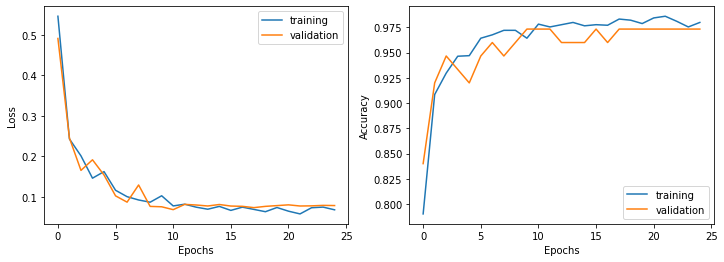

In [ ]:
history = history_curr
plt.figure(figsize=(12,4))
plt.subplot(121); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.subplot(122); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.savefig(savename[:-3]+'.png')

# training performance
train_accuracy = history.history['accuracy'][-1]
print('training accuracy = ' + str(train_accuracy))

# validation preformance
valid_accuracy = history.history['val_accuracy'][-1]
print('validation accuracy = ' + str(valid_accuracy))

# Heatmap

In [54]:
import cv2
from PIL import Image

# this is the only function that cannot be in a library
def heatmap_on_image(input_img,heatmap,threshold=0.6):
    heatmap = scaling01(heatmap)
    plt.figure(figsize=(36,12))
    plt.subplot(131); plt.imshow(input_img); plt.title('Original', fontsize=40); plt.axis('off')
    plt.subplot(132); plt.imshow(heatmap,cmap='jet'); plt.title('Heatmap', fontsize=40); plt.axis('off')
    img_zeros = np.zeros((input_img.shape))
    img_zeros[heatmap>=threshold,:]=input_img[heatmap>=threshold,:]
    plt.subplot(133); plt.imshow(img_zeros.astype(np.uint8)); plt.axis('off'); plt.title('Masked', fontsize=40)

def getCAM(conv,pred,w,scale):
    target = np.argmax(pred).squeeze()
    weights = w[:, target].numpy()
    heatmap = conv.squeeze() @ weights
    heatmap = zoom(heatmap, zoom=(scale, scale))
    return scaling01(heatmap)

def extract_maskedimage(input_img,heatmap,threshold=0.6):
    img_zeros = np.zeros(input_img.shape)
    img_zeros[heatmap>=threshold,:]=input_img[heatmap>=threshold,:]
    masked_heatmap = img_zeros.astype(int)
    return masked_heatmap

def create_masked_ds(ds_original,conv_v,pred_v,w,scale):
    ds_heatmap = []
    for k in range(ds_original.shape[0]):
        ds_heatmap.append(extract_maskedimage(ds_original[k],getCAM(conv_v[k],pred_v[k],w,scale)))
    return np.array(ds_heatmap)

def only_mask(shape,conv,pred,w,scale,threshold=0.6):
    ds_mask = []
    for k in range(conv.shape[0]):
        mask = np.zeros((shape[0:2]))
        heatmap = getCAM(conv[k],pred[k],w,scale)
        mask[heatmap>threshold]=1
        ds_mask.append(mask)
    return np.array(ds_mask)
  
def combine_mask(input_img,mask,mask_type):
    ds_mask3 = []
    for k in range(input_img.shape[0]):
        if mask_type=='_black':
            mask3 = np.zeros(input_img[0].shape)
            mask3[mask[k].astype(bool),:]=input_img[k,mask[k].astype(bool),:]
        if mask_type=='_blur':
          mask3=cv2.GaussianBlur(input_img[k],(7,7),3)
          mask3[mask[k].astype(bool),:]=input_img[k,mask[k].astype(bool),:]
        ds_mask3.append(mask3.astype(np.uint8))
    return np.array(ds_mask3)

def openingclosing(img):
    img = img.astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))     
    img_oc = cv2.dilate(img,kernel,iterations = 1)
    return img_oc

def intersect_images(imgs,n):
    intersect_masks = []
    for k in range(0,imgs.shape[0],n):
        threshold = n/2
        intersect = (imgs[k]==1).astype(int)+np.rot90((imgs[k+1]==1).astype(int),k=3)+np.rot90((imgs[k+2]==1).astype(int),k=2)+np.rot90((imgs[k+3]==1).astype(int),k=1)
        if n == 8:
            intersect = intersect+np.flipud(imgs[k+4]==1).astype(int)+np.rot90(np.flipud(imgs[k+5]==1).astype(int),k=1)+np.rot90(np.flipud(imgs[k+6]==1).astype(int),k=2)+np.rot90(np.flipud(imgs[k+7]==1).astype(int),k=3)
        intersect_mask = openingclosing(intersect>=threshold)
        if np.sum(intersect_mask)==0:
            intersect_mask = np.ones((intersect_mask.shape))
        intersect_masks.append(intersect_mask.astype(int))
    return np.array(intersect_masks)

In [38]:
my_global_branch = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/HDA/our_models/ourmodel_RGB_NOartifacts_resize224_8aug_our_nn_global_adamax_variable.h5')
my_global_branch.summary()

prova = '_' + my_global_branch.name + '_global'
optimizer_name = '_adamax_variable' 
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+name_aug+prova+optimizer_name+'.h5'

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 32  128         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 224, 224, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                            

In [35]:
scale = img_shape[0]/56
w, b = my_global_branch.get_layer("dense_1").weights
model_heatmap_global = keras.Model(inputs=my_global_branch.input, outputs=[my_global_branch.layers[-3].output, my_global_branch.layers[-1].output], name='model_heatmap_global')

In [ ]:
model_heatmap_global.summary()

Model: "model_heatmap_global"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 32  128         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 224, 224, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                              

1/1 [==============================] - 0s 17ms/step


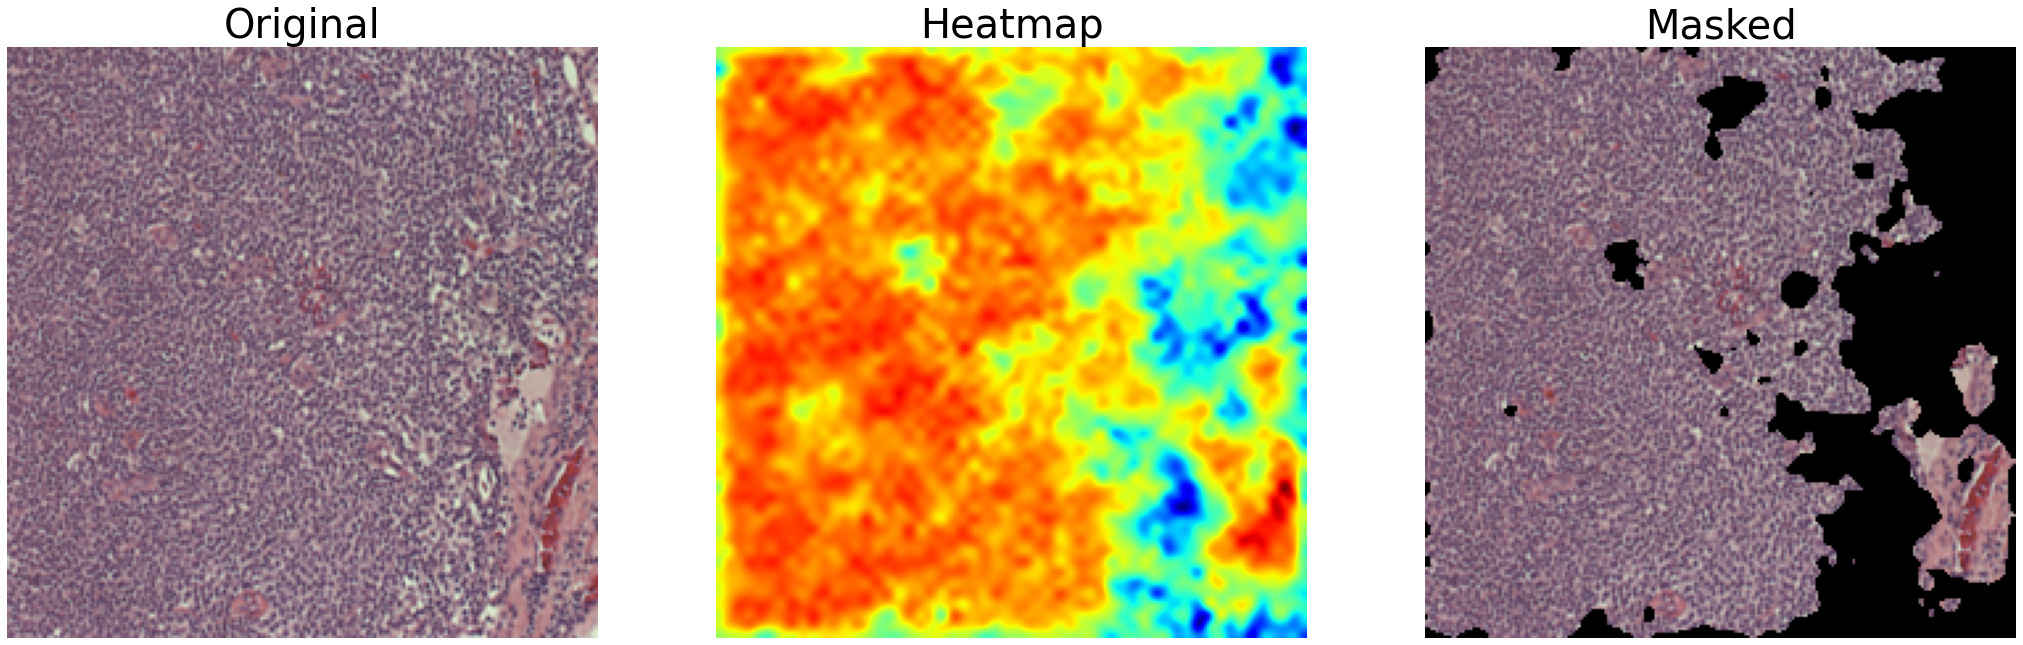

In [55]:
img_train = x_train_aug[0]
conv, pred = model_heatmap_global.predict(np.expand_dims(img_train,axis=0))
heatmap = getCAM(conv,pred,w,scale)
heatmap_on_image(img_train,heatmap)
plt.savefig(savename[:-3]+'heatmap.png')

In [40]:
conv_train, pred_train = model_heatmap_global.predict(x_train_aug)
conv_valid, pred_valid = model_heatmap_global.predict(x_valid)
conv_test, pred_test = model_heatmap_global.predict(x_test)

3/3 [==============================] - 0s 93ms/step


In [41]:
# create the masked images [0 1] with threshold = 0.6
inter ='_NoInter'
train_mask = only_mask(img_shape,conv_train,pred_train,w,scale)
valid_mask = only_mask(img_shape,conv_valid,pred_valid ,w,scale)
test_mask = only_mask(img_shape,conv_test,pred_test,w,scale)

In [42]:
# consider intersection or not
n = 8
inter = '_YesInter' 
train_mask = intersect_images(train_mask,n)
train_mask = np.concatenate((list(map(lambda img: data_augmentation(img),train_mask))))

In [43]:
mask_type = '_black' # black or blur
ds_hm_train = combine_mask(x_train_aug,train_mask,mask_type=mask_type)
ds_hm_valid = combine_mask(x_valid,valid_mask,mask_type=mask_type)
ds_hm_test = combine_mask(x_test,test_mask,mask_type=mask_type)
print('Train mask shape:',ds_hm_train.shape,'\nValid mask shape:',ds_hm_valid.shape)

Train mask shape: (1792, 224, 224, 3) 
Valid mask shape: (75, 224, 224, 3)


In [ ]:
ind = 0
k = range(ind*8,(ind+1)*8)
intersect4_0 = (ds_hm_train[k[0]].mean(axis=2)==0).astype(int)+np.rot90((ds_hm_train[k[1]].mean(axis=2)==0).astype(int),k=3)+np.rot90((ds_hm_train[k[2]].mean(axis=2)==0).astype(int),k=2)+np.rot90((ds_hm_train[k[3]].mean(axis=2)==0).astype(int),k=1)
intersect4_1 = np.flipud(ds_hm_train[k[4]].mean(axis=2)==0).astype(int)+np.rot90(np.flipud(ds_hm_train[k[5]].mean(axis=2)==0).astype(int),k=1)+np.rot90(np.flipud(ds_hm_train[k[6]].mean(axis=2)==0).astype(int),k=2)+np.rot90(np.flipud(ds_hm_train[k[7]].mean(axis=2)==0).astype(int),k=3)
intersect = abs(intersect4_0+intersect4_1-8)
plt.figure(figsize=(20,12),frameon=False)
plt.subplot(131); plt.imshow(intersect,cmap='hot'); plt.axis('off')
plt.subplot(132); plt.imshow((intersect>=4).astype(int),cmap='gray'); plt.axis('off')
plt.subplot(133); plt.imshow(openingclosing(intersect>=4),cmap='gray'); plt.axis('off')
print('Max intersection:',str(round(intersect.max()))+'/8\nMin intersection:',str(round(intersect.min()))+'/8')
# plt.savefig(path+'figures/intersectiongood.png')

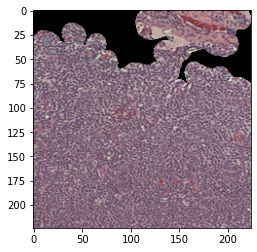

In [44]:
plt.imshow(ds_hm_train[1])

In [45]:
labels_train = utils_ds.convert_to_one_hot(np.array(y_train_aug), 3).T 
labels_valid = utils_ds.convert_to_one_hot(np.array(y_valid), 3).T
batch_size = 32
tf_hm_train = utils_ds.create_tf_dataset(ds_hm_train, labels_train, batch_size, normalize=False, shuffle=True, repeat=False, cache_file=False)
tf_hm_valid = utils_ds.create_tf_dataset(ds_hm_valid, labels_valid, batch_size, normalize=False, shuffle=False, repeat=False, cache_file=False)

print(tf.data.experimental.cardinality(tf_hm_train)); print(tf_hm_train)
print(tf.data.experimental.cardinality(tf_hm_valid)); print(tf_hm_valid)

tf.Tensor(56, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
tf.Tensor(3, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>


In [ ]:
threshold = 4
count = []; num_reg = []
for ind in range(0,224):
    k = range(ind*8,(ind+1)*8)
    intersect4_0 = (ds_hm_train[k[0]].mean(axis=2)==0).astype(int)+np.rot90((ds_hm_train[k[1]].mean(axis=2)==0).astype(int),k=3)+np.rot90((ds_hm_train[k[2]].mean(axis=2)==0).astype(int),k=2)+np.rot90((ds_hm_train[k[3]].mean(axis=2)==0).astype(int),k=1)
    intersect4_1 = np.flipud(ds_hm_train[k[4]].mean(axis=2)==0).astype(int)+np.rot90(np.flipud(ds_hm_train[k[5]].mean(axis=2)==0).astype(int),k=1)+np.rot90(np.flipud(ds_hm_train[k[6]].mean(axis=2)==0).astype(int),k=2)+np.rot90(np.flipud(ds_hm_train[k[7]].mean(axis=2)==0).astype(int),k=3)
    intersect = abs(intersect4_0+intersect4_1-8)>=threshold
    intersect = openingclosing(intersect)
    count.append(intersect.sum())
    num_labels, labels_im = cv2.connectedComponents(((intersect).astype(int)*255).astype(np.uint8))
    num_reg.append(num_labels-1)
count = np.array(count); num_reg = np.array(num_reg)
print('Count: mean',round(count.mean()),'max',count.max(),'min',count.min())
print('Number of regions: mean',round(num_reg.mean()),'max',num_reg.max(),'min',num_reg.min())
print(np.where(count == 0)[0])

Count: mean 33924 max 50176 min 1074
Number of regions: mean 2 max 9 min 1
[]


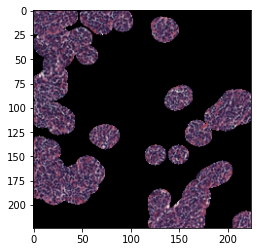

In [46]:
plt.imshow(ds_hm_train[150].astype(int))

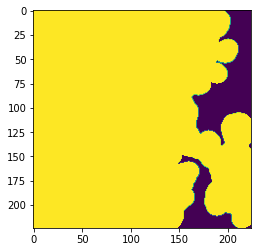

In [47]:
count = []; num_reg = []; count_all = [];
for ind in range(0,224):
    k = range(ind*8,(ind+1)*8)
    # align the masked images
    intersect4_0 = (ds_hm_train[k[0]].mean(axis=2)==0).astype(int) # binary images
    if ind == 0:
      plt.imshow(intersect4_0)
    intersect4_1 = np.rot90((ds_hm_train[k[1]].mean(axis=2)==0).astype(int),k=3)
    intersect4_2 = np.rot90((ds_hm_train[k[2]].mean(axis=2)==0).astype(int),k=2)
    intersect4_3 = np.rot90((ds_hm_train[k[3]].mean(axis=2)==0).astype(int),k=1)
    intersect4_4 = np.flipud(ds_hm_train[k[4]].mean(axis=2)==0).astype(int)
    intersect4_5 = np.rot90(np.flipud(ds_hm_train[k[5]].mean(axis=2)==0).astype(int),k=1)
    intersect4_6 = np.rot90(np.flipud(ds_hm_train[k[6]].mean(axis=2)==0).astype(int),k=2)
    intersect4_7 = np.rot90(np.flipud(ds_hm_train[k[7]].mean(axis=2)==0).astype(int),k=3)
    # sum all the aligned masked images
    intersect0 = intersect4_0+intersect4_1+intersect4_2+intersect4_3+intersect4_4+intersect4_5+intersect4_6+intersect4_7
    #print(intersect0)
    intersect = abs(intersect0-8)>=4 # we created combined the eigth masks by setting to 1 the pixels which were equal to 1 in at learst 4 images 
    if ind == 0:
      plt.imshow(intersect)
    count_all.append(intersect.sum()/(abs(intersect0-8)>=1).sum()) # number of non-zero pixels/number of pixels in which at least 1 image that pixel is non-zero
    # we want to understand which images present no intersections
    num_labels, labels_im = cv2.connectedComponents(((intersect).astype(int)*255).astype(np.uint8))
    num_reg.append(num_labels-1)
    
num_reg = np.array(num_reg); 
count_all = np.array(count_all);

In [48]:
print(count_all.mean())
print(count_all.std()/count_all.mean())
print(count_all.max()) # most overlapping case
print(count_all.min()) # # most overlapping case

1.0
0.0
1.0
1.0


# Local branch

In [ ]:
my_local_branch = our_nn(img_shape)
my_local_branch.summary()

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                            

In [ ]:
epochs = 25
prova = '_' + my_local_branch.name + '_local'
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=56*40, decay_rate=.0001) 
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
optimizer_name = '_adamax_variable'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+name_aug+prova+inter+mask_type+optimizer_name+'.h5'
saving = ModelSaveCallback(savename)
my_local_branch.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_curr = my_local_branch.fit(tf_hm_train, epochs=epochs, verbose='auto', validation_data=tf_hm_valid, callbacks=[saving], steps_per_epoch=train_steps, validation_steps=valid_steps)
np.save(savename[:-3]+'_history.npy',history_curr.history)

Epoch 1/25
 6/56 [==>...........................] - ETA: 15s - loss: 0.8021 - accuracy: 0.5781

56/56 [==============================] - 22s 329ms/step - loss: 0.4397 - accuracy: 0.8170 - val_loss: 1.3092 - val_accuracy: 0.3333
Epoch 2/25
56/56 [==============================] - 19s 332ms/step - loss: 0.1773 - accuracy: 0.9353 - val_loss: 0.8361 - val_accuracy: 0.6267
Epoch 3/25
56/56 [==============================] - 19s 335ms/step - loss: 0.1266 - accuracy: 0.9626 - val_loss: 0.8855 - val_accuracy: 0.6267
Epoch 4/25
56/56 [==============================] - 19s 338ms/step - loss: 0.1109 - accuracy: 0.9660 - val_loss: 1.0481 - val_accuracy: 0.6133
Epoch 5/25
56/56 [==============================] - 20s 349ms/step - loss: 0.1128 - accuracy: 0.9632 - val_loss: 1.3265 - val_accuracy: 0.6267
Epoch 6/25
56/56 [==============================] - 19s 339ms/step - loss: 0.1027 - accuracy: 0.9654 - val_loss: 1.5875 - val_accuracy: 0.6133
Epoch 7/25
56/56 [==============================] - 19s 341ms/step - loss: 0.0844 - accuracy: 0.9754 - val_loss: 1.6218 - val_accuracy: 0.6133
Epoch 8/25

training accuracy = 0.9910714030265808
validation accuracy = 0.8266666531562805


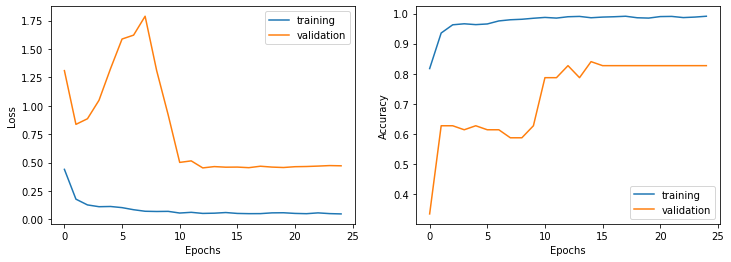

In [ ]:
history = history_curr
plt.figure(figsize=(12,4))
plt.subplot(121); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.subplot(122); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.savefig(savename[:-3]+'.png')

# training performance
train_accuracy = history.history['accuracy'][-1]
print('training accuracy = ' + str(train_accuracy))

# validation preformance
valid_accuracy = history.history['val_accuracy'][-1]
print('validation accuracy = ' + str(valid_accuracy))

# Fusion branch

In [ ]:
my_global_branch = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/HDA/our_models/ourmodel_RGB_NOartifacts_resize224_8aug_our_nn_global_adamax_variable.h5')
my_global_branch.summary()

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 32  128         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 224, 224, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                            

In [ ]:
my_local_branch = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/HDA/our_models/ourmodel_RGB_NOartifacts_resize224_8aug_our_nn_local_YesInter_black_adamax_variable.h5')
my_local_branch.summary()

Model: "our_nn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                            

In [ ]:
model_pool_local_branch = tf.keras.Model(inputs=my_local_branch.input, outputs=my_local_branch.layers[-2].output, name='model_pool_local_branch')
x_l_train, x_l_valid, x_l_test = model_pool_local_branch.predict(ds_hm_train), model_pool_local_branch.predict(ds_hm_valid), model_pool_local_branch.predict(ds_hm_test)

model_pool_global_branch = tf.keras.Model(inputs=my_global_branch.input, outputs=my_global_branch.layers[-2].output, name='model_pool_global_branch');
x_g_train, x_g_valid, x_g_test = model_pool_global_branch.predict(x_train_aug), model_pool_global_branch.predict(x_valid), model_pool_global_branch.predict(x_test)

print(x_g_train.shape,x_g_valid.shape,x_g_test.shape)
print(x_l_train.shape,x_l_valid.shape,x_l_test.shape)

3/3 [==============================] - 0s 90ms/step
(1792, 128) (75, 128) (75, 128)
(1792, 128) (75, 128) (75, 128)


In [ ]:
shape = (128+128)
my_fusion_branch = fusion_branch(shape)
my_fusion_branch.summary()

Model: "fusion_branch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_fusion_branch (InputL  [(None, 256)]            0         
 ayer)                                                           
                                                                 
 batch_normalization_17 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,795
Trainable params: 1,283
Non-trainable params: 512
_________________________________________________________________


In [ ]:
epochs = 25
prova = '_' + my_fusion_branch.name
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=56*40, decay_rate=.0001) 
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
optimizer_name = 'adamax_variable'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
savename = path+'/our_models/ourmodel_'+filename[8:-3]+'_'+name_aug+prova+inter+mask_type+optimizer_name+'.h5'
saving = ModelSaveCallback(savename)
my_fusion_branch.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
x_concat_train = np.concatenate([x_g_train,x_l_train],axis=1)
x_concat_valid = np.concatenate([x_g_valid,x_l_valid],axis=1)

labels_train = utils_ds.convert_to_one_hot(np.array(y_train_aug), 3).T 
labels_valid = utils_ds.convert_to_one_hot(np.array(y_valid), 3).T

tf_fus_train = utils_ds.create_tf_dataset(x_concat_train, labels_train, batch_size=32, normalize=False, shuffle=True, repeat=False, cache_file=False)
tf_fus_valid = utils_ds.create_tf_dataset(x_concat_valid, labels_valid, batch_size=32, normalize=False, shuffle=False, repeat=False, cache_file=False)

print(tf.data.experimental.cardinality(tf_fus_train)); print(tf_fus_train)
print(tf.data.experimental.cardinality(tf_fus_valid)); print(tf_fus_valid)

tf.Tensor(56, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
tf.Tensor(3, shape=(), dtype=int64)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>


In [ ]:
print(x_concat_train.shape)
print(x_concat_valid.shape)
print(labels_train.shape)
print(labels_test.shape)


(1792, 256)
(75, 256)
(1792, 3)
(75, 3)


In [ ]:
history_curr = my_fusion_branch.fit(tf_fus_train, epochs=epochs, verbose='auto', validation_data=tf_fus_valid, callbacks=[saving])
np.save(savename[:-3]+'_history.npy',history_curr.history)

Epoch 1/25
56/56 [==============================] - 1s 5ms/step - loss: 0.2648 - accuracy: 0.9185 - val_loss: 0.2288 - val_accuracy: 0.9467
Epoch 2/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.9467
Epoch 3/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9467
Epoch 4/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0436 - accuracy: 0.9972 - val_loss: 0.1320 - val_accuracy: 0.9467
Epoch 5/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.9333
Epoch 6/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.9983 - val_loss: 0.1271 - val_accuracy: 0.9333
Epoch 7/25
56/56 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 0.9989 - val_loss: 0.1270 - val_accuracy: 0.9333
Epoch 8/25
56/56 [==

training accuracy = 0.9983258843421936
validation accuracy = 0.9333333373069763


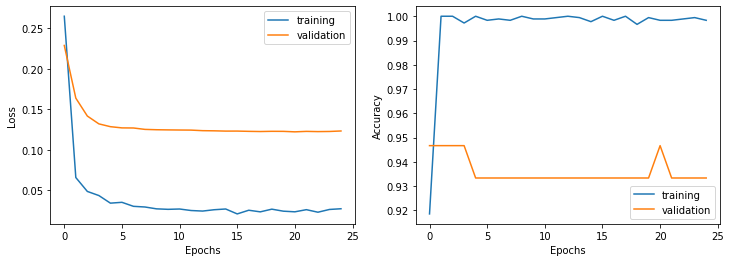

In [ ]:
history = history_curr
plt.figure(figsize=(12,4))
plt.subplot(121); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.subplot(122); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.legend(['training','validation']); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.savefig(savename[:-3]+'.png')

# training performance
train_accuracy = history.history['accuracy'][-1]
print('training accuracy = ' + str(train_accuracy))

# validation preformance
valid_accuracy = history.history['val_accuracy'][-1]
print('validation accuracy = ' + str(valid_accuracy))

This approach doesn't work on our dataset. Maybe is due to the fact that we are considering microscopic images.